In [1]:
from omicron import init_db
from jqdatasdk import finance, query
import pickle
init_jq()

NameError: name 'init_jq' is not defined

In [8]:
def get_fund_list(kind=[402001, 402004]):
    q_ = query(finance.FUND_MAIN_INFO).filter(finance.FUND_MAIN_INFO.underlying_asset_type_id.in_(kind))
    
    dfs = []
    for i in range(100):
        q = q_.limit(3000).offset(i * 3000)
        df = finance.run_query(q)
        if len(df) > 0:
            dfs.append(df)
        else:
            break
    
    return pd.concat(dfs)

def get_fund_codes(funds):
    return funds['main_code'].tolist()

def code2name(fund, code):
    return fund[fund['main_code'] == code].iloc[0]["name"]

def preprocess(all_funds):
    path = os.path.expanduser("~/data/fund.tsv")
    with open(path, "r") as f:
        lines = f.readlines()
        
    records = {}
    
    scope = set(all_funds["main_code"].tolist())
    for line in lines:
        code, sum_value, day, _ = line.split("\t")
        if code == "code" or not (code in scope):
            continue

        name = all_funds[all_funds["main_code"] == code].iloc[0]["name"]

        values = records.get(name, [])
        values.append((day, sum_value))
        records[name] = values
        
    for name, values in records.items():
        records[name] = sorted(values, key = lambda x: x[0])
        
    return records

    
def get_acc_value(code, n):
    q=query(finance.FUND_NET_VALUE).filter(finance.FUND_NET_VALUE.code == code).order_by(finance.FUND_NET_VALUE.day.desc()).limit(n)
    
    df=finance.run_query(q)
    return df['sum_value'].values

def batch_get_acc_value(codes, n):
    results = {}
    
    for code in codes:
        values = get_acc_value(code, n)
        results[code] = values
        
    return results

def fund_values_to_array(fund_records):
    codes = []
    X = []
    
    for code, values in fund_records.items():
        if len(values) < 30 or np.any(np.isnan(values.astype(float))):
            continue
        codes.append(code)
        X.append(values)
    return np.array(codes), np.array(X, dtype="<f4")

def _rank_array(X, W=None, ascending=False):
    """将二维数组X按行进行排序。
    
    先将数组按列求各单元在每列中的排名（从小到大），再按行对各列中的排名进行加权统计
    """
    
    if W is None:
        n = X.shape[1]
        W = np.arange(1,n+1) / (n+1)
        
    df = pd.DataFrame(X)
    rank = df.rank(pct=True).dot(W.transpose())
    
    return rank.sort_values(ascending=ascending)

def rank_fund(all_funds, net_values):
    codes, X = fund_values_to_array(net_values)
    
    rank = _rank_array(X)
    
    return [code2name(all_funds, code) for code in codes[rank.index]]
        
def fetch_fund_values(funds):
    codes = get_fund_codes(funds)
    
    values = batch_get_acc_value(codes, 30)
    return values
    
funds = get_fund_list()
fund_values = fetch_fund_values(funds)
rank_fund(funds, fund_values)

NameError: name 'all_funds' is not defined

In [ ]:
all_funds = get_fund_list()

In [10]:
data = preprocess(all_funds)

In [27]:
bars = jq.get_bars("000001.XSHG", 100, "1d", df=False)

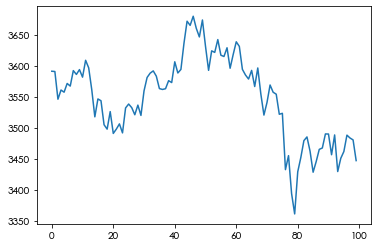

In [29]:
close = bars["close"]

In [33]:
from scipy.signal import savgol_filter
from zigzag import peak_valley_pivots

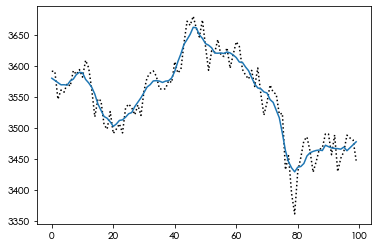

In [32]:
plt.plot(close, ":", color="k")
plt.plot(savgol_filter(close, 7, 1))

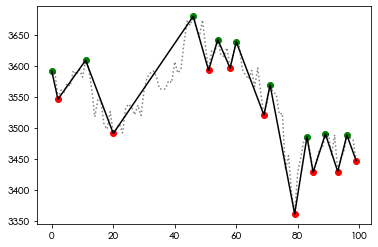

In [41]:
def show_peaks_valleys(y):
    pivots = peak_valley_pivots(y, 0.01, -0.01)
    
    plt.plot(np.arange(len(y)), y, "k:", alpha=0.5)
    plt.plot(np.arange(len(y))[pivots != 0], y[pivots != 0], 'k-')
    plt.scatter(np.arange(len(y))[pivots == 1], y[pivots == 1], color='g')
    plt.scatter(np.arange(len(y))[pivots == -1], y[pivots == -1], color='r')

In [102]:
def support_resist_lines(
    ts: np.ndarray, upthres: float = 0.01, downthres: float = -0.01
):
    """计算时间序列的支撑线和阻力线

    Args:
        ts (np.ndarray): [description]

    Returns:
        (np.ndarray, np.ndarray): 阻力线和支撑线的一元多项式系数
    """
    pivots = peak_valley_pivots(ts, upthres, downthres)

    arg_max = np.where(pivots == 1)[0]
    arg_min = np.where(pivots == -1)[0]

    resist = None
    support = None

    if len(arg_max) >= 2:
        x = arg_max[-3:]
        y = ts[x]
        coeff = np.polyfit(x, y, deg=1)

        resist = np.poly1d(coeff)

    if len(arg_min) >= 2:
        x = arg_min[-3:]
        y = ts[x]
        coeff = np.polyfit(x, y, deg=1)

        support = np.poly1d(coeff)

    return support, resist

In [83]:
from enum import IntEnum

class BreakoutFlag(IntEnum):
    UP = 1
    DOWN = -1
    NONE = 0
def breakout(ts: np.ndarray, upthres: float = 0.01, downthres: float = -0.01) -> BreakoutFlag:
    """检测时间序列是否突破了压力线（整理线）

    Args:
        ts (np.ndarray): 时间序列

    Returns:
        如果上向突破压力线，返回1，如果向下突破压力线，返回-1，否则返回0
    """
    resist, support = support_resist_lines(ts, upthres, downthres)

    if resist is not None:
        if ts[-1] > resist(len(ts) - 1):
            return BreakoutFlag.UP
            
    if support is not None:
        if ts[-1] < support(len(ts) - 1):
            return BreakoutFlag.DOWN

    return BreakoutFlag.NONE

In [78]:
close = close.tolist().copy()
close.append(3500)

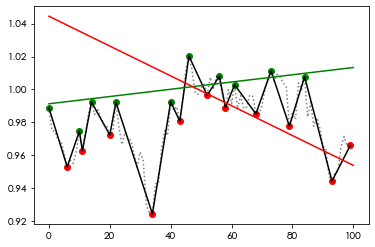

In [104]:
def show_support_resist_lines(ts):
    show_peaks_valleys(ts)
    
    support, resist = support_resist_lines(ts)
    x = np.arange(len(ts) + 1)
    
    yresist = resist(x)
    ysupport = support(x)
    
    plt.plot(x, yresist, 'g')
    plt.plot(x, ysupport, 'r')
    
np.random.seed(1978)
X = np.cumprod(1 + np.random.randn(100) * 0.01)
show_support_resist_lines(X)

In [95]:
resist, support = support_resist_lines(X)

In [107]:
list(range(100 - 2, 100))

[98, 99]

In [2]:
from alpha.notebook import *

ImportError: cannot import name 'cross' from 'omicron.extensions.np' (/Users/aaronyang/miniforge3/envs/alpha/lib/python3.8/site-packages/omicron/extensions/np.py)

In [8]:
import os
os.getenv("JQ_PASSWORD")

'Ohc46jiGWRpc'

In [10]:
import jqdatasdk as jq
jq.auth("15318248820", "Ohc46jiGWRpc")

auth success 


In [7]:
jq.logout()

已退出
